In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [89]:
import numpy as np
import cv2

In [3]:
import tensorflow as tf
slim = tf.contrib.slim

In [4]:
import sys
sys.path.append('../')

from preprocessing import ssd_vgg_preprocessing
from nets import ssd_vgg_300, np_methods
from notebooks import visualization

In [87]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [5]:
isess = tf.InteractiveSession()

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
#data_format = 'NCHW'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))

In [7]:
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)

image_4d = tf.expand_dims(image_pre, 0)

In [15]:
a = image_pre.eval(feed_dict={img_input: img})
a.shape

(300, 300, 3)

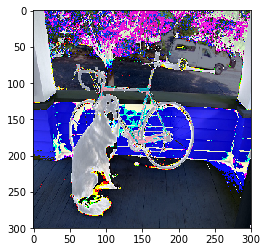

In [16]:
plt.imshow(np.uint8(a))

In [22]:
b = bbox_img.eval()

In [23]:
b

array([ 0.,  0.,  1.,  1.], dtype=float32)

In [8]:
# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

In [9]:
# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [10]:
# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

In [164]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[8])

In [165]:
%%time
# Run SSD network.
rimg, rpredictions, rlocalisations, rbbox_img = isess.run(
    [image_4d, predictions, localisations, bbox_img],
    feed_dict={img_input: img})

Wall time: 1.21 s


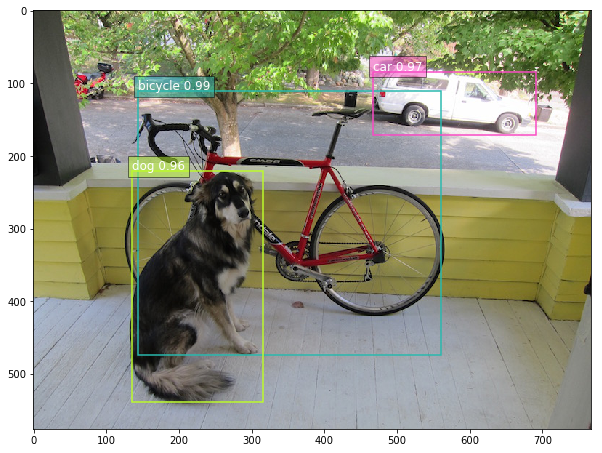

In [166]:
select_threshold=0.5
nms_threshold=.45

# Get classes and bboxes from the net outputs.
rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
        rpredictions, rlocalisations, ssd_anchors,
        select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)

rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
# Resize bboxes to original image shape. Note: useless for Resize.WARP!
rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)

visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

## Raw SSD output: multiple detections after simple thresholding

In [167]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        if show_text:
            s = '%s: %s' % ('Car', scores[i])    
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        
def plot_image(img, title='', figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)
    axes.set_title(title, fontsize=20)

In [235]:
select_threshold=0.1

# Get classes and bboxes from the net outputs.
rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
        rpredictions, rlocalisations, ssd_anchors,
        select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)

print(rclasses.shape)
print(np.unique(rclasses))

(36,)
[ 2  7 12 14]


In [236]:
# Remove other classes than cars.
idxes = ((rclasses == 2) | (rclasses == 14))
rclasses = rclasses[idxes]
rscores = rscores[idxes]
rbboxes = rbboxes[idxes]

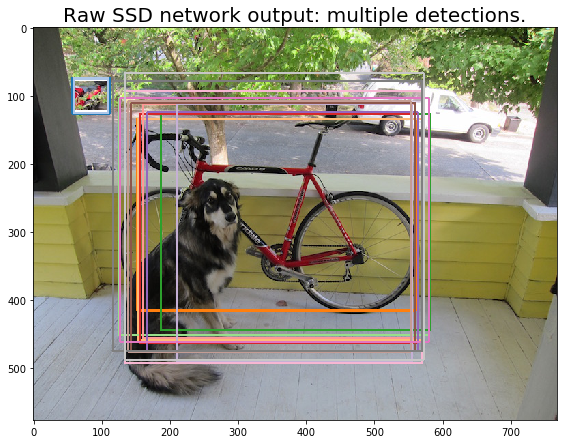

In [237]:
# Draw bboxes of detected objects.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
plot_image(img_bboxes, 'Raw SSD network output: multiple detections.', (8, 8))

In [18]:
import random
class_names = ["background", "aeroplane", "bicycle", "bird", "boat",
               "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
               "sofa", "train", "monitor"]

def plt_bb(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):

    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0] #332
    width = img.shape[1]  #500
    colors = dict()
    for i in range(classes.shape[0]): #2
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            #class_name = str(cls_id)
            class_name = class_names[cls_id]
            plt.gca().text(xmin, ymin - 2,
                           '{:s} {:.2f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=12, color='white')
    #plt.show()


In [19]:
int(rbboxes[0, 0] * 332)

102

In [20]:
import cv2

In [35]:
cv2.rectangle?

In [52]:
orig_image = cv2.imread("../demo/000022.jpg")

In [53]:
to_draw = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

In [55]:
to_draw = cv2.imread("../demo/000022.jpg")
to_draw = cv2.cvtColor(to_draw, cv2.COLOR_BGR2RGB)

height = to_draw.shape[0] #332
width = to_draw.shape[1]  #500

colors = dict()

for i in range(rclasses.shape[0]): #2
    cls_id = int(rclasses[i])
    if cls_id >= 0:
        score = rscores[i]
        if cls_id not in colors:
            colors[cls_id] = (random.random(), random.random(), random.random())
        ymin = int(rbboxes[i, 0] * height)
        xmin = int(rbboxes[i, 1] * width)
        ymax = int(rbboxes[i, 2] * height)
        xmax = int(rbboxes[i, 3] * width)
        cv2.rectangle(to_draw, (xmin, ymin), (xmax, ymax), colors[cls_id], 2)
        
        text_top = (xmin, ymin-10)
        text_bot = (xmin + 80, ymin + 5)
        text_pos = (xmin + 5, ymin)
        cv2.rectangle(to_draw, text_top, text_bot, colors[cls_id], -1)
        
        text = class_names[cls_id] + " " + ('%.2f' % score)
        cv2.putText(to_draw, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)

In [56]:
colors[cls_id]

(0.21514836217527555, 0.9713448141884492, 0.0707350981307957)

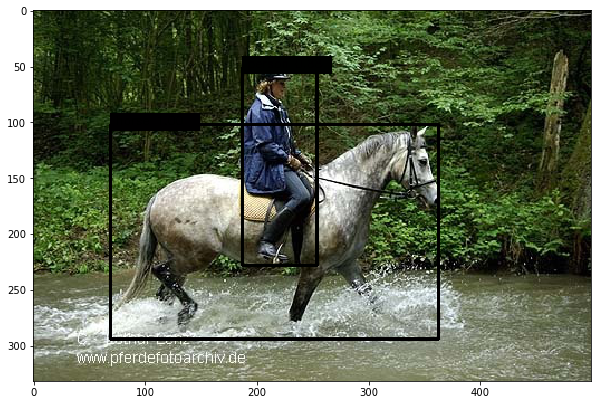

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(to_draw)

In [1]:
import cv2

In [22]:
vid = cv2.VideoCapture(1)

In [23]:
vid.get(cv2.CAP_PROP_FRAME_WIDTH)

640.0

In [25]:
vid.get(cv2.CV_CAP_PROP_MODE)

AttributeError: module 'cv2' has no attribute 'CV_CAP_PROP_MODE'